# Обучение модели

В качестве модели была выбрана ultralitics yolov5. Поскольку спутниковые снимки имеют большой размер, а объекты маленькие, то перед обучением необходимо разбить фотографии на более мелкие изображения.

In [4]:
import json
import numpy as np
from PIL import Image
from tqdm import tqdm
import pandas as pd
import os

Функция для создания аннотаций к изображениям, полученным в ходе разбиения исходного изображения:

In [3]:
def mini_labels(labels, box, min_area=12):
    '''Создает bbox для объектов, находящихся внутри части изображения, ограниченного рамками box'''
    new_boxs=[]
    for item in labels:
        cat_name, label = item[0], item[1]
        if not (
            (box[2]<label['bbox'][0]) or
            (label['bbox'][2]<box[0]) or
            (box[3]<label['bbox'][1]) or
            (label['bbox'][3]<box[1])
           ):
            seg = []
            for it in label['seg']:
                seg += it
            seg = np.array(seg)
            new_seg = np.zeros(seg.shape)
            x_seg = seg[::2]
            y_seg = seg[1::2]
            x_seg[x_seg < box[0]] = box[0]
            x_seg[x_seg > box[2]] = box[2]
            y_seg[y_seg < box[1]] = box[1]
            y_seg[y_seg > box[3]] = box[3]
            new_seg[::2] = x_seg
            new_seg[1::2] = y_seg
            if (np.max(new_seg[::2])-np.min(new_seg[::2]))*(np.max(new_seg[1::2])-np.min(new_seg[1::2])) > min_area:
                new_boxs.append([cat_name, [np.min(new_seg[::2]) - box[0],
                                          np.min(new_seg[1::2]) - box[1],
                                          np.max(new_seg[::2]) - box[0],
                                          np.max(new_seg[1::2]) - box[1]]])
    return new_boxs

Функция для разбивания изображений:

In [33]:
def splitter(mode, annotations_path, img_dir_input, output_dir, frame_size, min_area) -> None:
    '''mode - тип выборки (val/train)
       annotations_path - путь к аннотациам
       img_dir_input - путь к снимкам
       output_dir - директория, куда будут сохраняться результаты
       frame_size - приблизительный размер получаемых изображений
       min_area - минимальная площадь объектов (в пикселях), которые маркируются'''
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir+f'{mode}/labels/')
        os.makedirs(output_dir+f'{mode}/images/')
    else:
        print('Такая директория уже существет!')
        return
    label_output_path=output_dir+f'{mode}/labels/'
    img_output_path=output_dir+f'{mode}/images/'
    
    name2id={'storage_tank': 0,
     'Large_Vehicle': 1,
     'Small_Vehicle': 2,
     'plane': 3,
     'ship': 4,
     'Swimming_pool': 5,
     'Harbor': 6,
     'tennis_court': 7,
     'Ground_Track_Field': 8,
     'Soccer_ball_field': 9,
     'baseball_diamond': 10,
     'Bridge': 11,
     'basketball_court': 12,
     'Roundabout': 13,
     'Helicopter': 14}
    
    with open(annotations_path, 'r', encoding='Utf-8') as json_data:
        annotations = json.load(json_data)
    
    img_ann = {}
    for img in annotations['images']:
        img_ann[img['id']] = []
    for obj in annotations['annotations']:
        img_ann[obj['image_id']].append([obj['category_name'], {'bbox': [obj['bbox'][0],obj['bbox'][1],obj['bbox'][0]+obj['bbox'][2]-1,obj['bbox'][1]+obj['bbox'][3]-1], 'seg': obj['segmentation']}])
    
    for img in tqdm(annotations['images']):
        im = Image.open(img_dir_input+img['file_name'])
        im = im.convert('RGB')
        img_name = img['file_name'][:5]
        width, height = im.size
        m=width//frame_size
        n=height//frame_size
        if n==0:
            n=1
        if m==0:
            m=1
        mini_width = width // m
        mini_height = height // n
        for i in range(n):
            for j in range(m):
                if (i==n-1) and (j==m-1):
                    box = (j*mini_width, i*mini_height, width, height)
                elif i==n-1:
                    box = (j*mini_width, i*mini_height, j*mini_width + mini_width, height)
                elif j==m-1:
                    box = (j*mini_width, i*mini_height, width, i*mini_height + mini_height)
                elif (i < n-1) and (j < m-1):
                    box = (j*mini_width, i*mini_height, j*mini_width + mini_width, i*mini_height + mini_height)
                labels = mini_labels(img_ann[img['id']], box, min_area)
                if len(labels)!=0:
                    for label in labels:
                        cat_name, bbox = label[0], label[1]
                        if ((((bbox[0]+bbox[2])/2.0)/mini_width >= 1.0) or
                            (((bbox[1]+bbox[3])/2.0)/mini_height >= 1.0)):
                            continue
                        obj_width = (bbox[2]-bbox[0])/mini_width
                        obj_height = (bbox[3]-bbox[1])/mini_height
                        if obj_width >= 1.0:
                            obj_width = 1.0 - 1e-6
                        if obj_height >= 1.0:
                            obj_height = 1.0 - 1e-6
                        line = ' '.join([
                                       str(name2id[cat_name]),
                                       str(((bbox[0]+bbox[2])/2.0)/mini_width),
                                       str(((bbox[1]+bbox[3])/2.0)/mini_height),
                                       str(obj_width),
                                       str(obj_height)
                                      ])
                        with open(label_output_path + f'{img_name}_{i}_{j}.txt','a') as file:
                            file.write(line + '\n')
                    im.crop(box).save(img_output_path + f'{img_name}_{i}_{j}.jpg')
                    

Изображения разбиваются на снимки размером около 600x600 пикселей:

In [22]:
mode = 'train'
annotations_path = f'C:/Users/Vlad/Desktop/Isaid_dataset/train/iSAID_train.json'
img_dir_input = f'C:/Users/Vlad/Desktop/Isaid_dataset/train/images/'
output_dir = 'datasets/isaid_yolov5/isaid_yolov5/'
frame_size = 600
min_area = 12
splitter(mode, annotations_path, img_dir_input, output_dir, frame_size, min_area)

Такая директория уже существет!


In [21]:
mode = 'val'
annotations_path = f'C:/Users/Vlad/Desktop/Isaid_dataset/val/iSAID_val.json'
img_dir_input = f'C:/Users/Vlad/Desktop/Isaid_dataset/val/images/'
splitter(mode, annotations_path, img_dir_input, output_dir, frame_size, min_area)

Такая директория уже существет!


Скачиваем саму модель:

In [5]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...


In [24]:
%cd yolov5

C:\Users\Vlad\Desktop\Yolov5\yolov5


In [7]:
!pip install -r requirements.txt

Проверяем конфигурацию для обучения:

In [24]:
import torch
import utils
display = utils.notebook_init()

YOLOv5  v7.0-254-gba63208 Python-3.9.13 torch-2.1.2+cu121 CUDA:0 (NVIDIA GeForce RTX 2050, 4096MiB)


Setup complete  (16 CPUs, 15.7 GB RAM, 438.8/463.2 GB disk)


Также нужно создать yaml-файл с описанием датасета:

In [25]:
dataset_info=f'''path: ../{output_dir}
train: train/images  
val: val/images

nc: 15
names: ['storage_tank',
 'Large_Vehicle',
 'Small_Vehicle',
 'plane',
 'ship',
 'Swimming_pool',
 'Harbor',
 'tennis_court',
 'Ground_Track_Field',
 'Soccer_ball_field',
 'baseball_diamond',
 'Bridge',
 'basketball_court',
 'Roundabout',
 'Helicopter']'''
with open('data/custom_dataset.yaml', 'w') as f:
    f.write(dataset_info)

Обучаем модель:

In [ ]:
!python train.py --img 640 --batch 16 --epochs 50 --data custom_dataset.yaml --weights yolov5s.pt --device 0

## Результаты

В результате обучения в течение 50 эпох были получены следующие результаты:

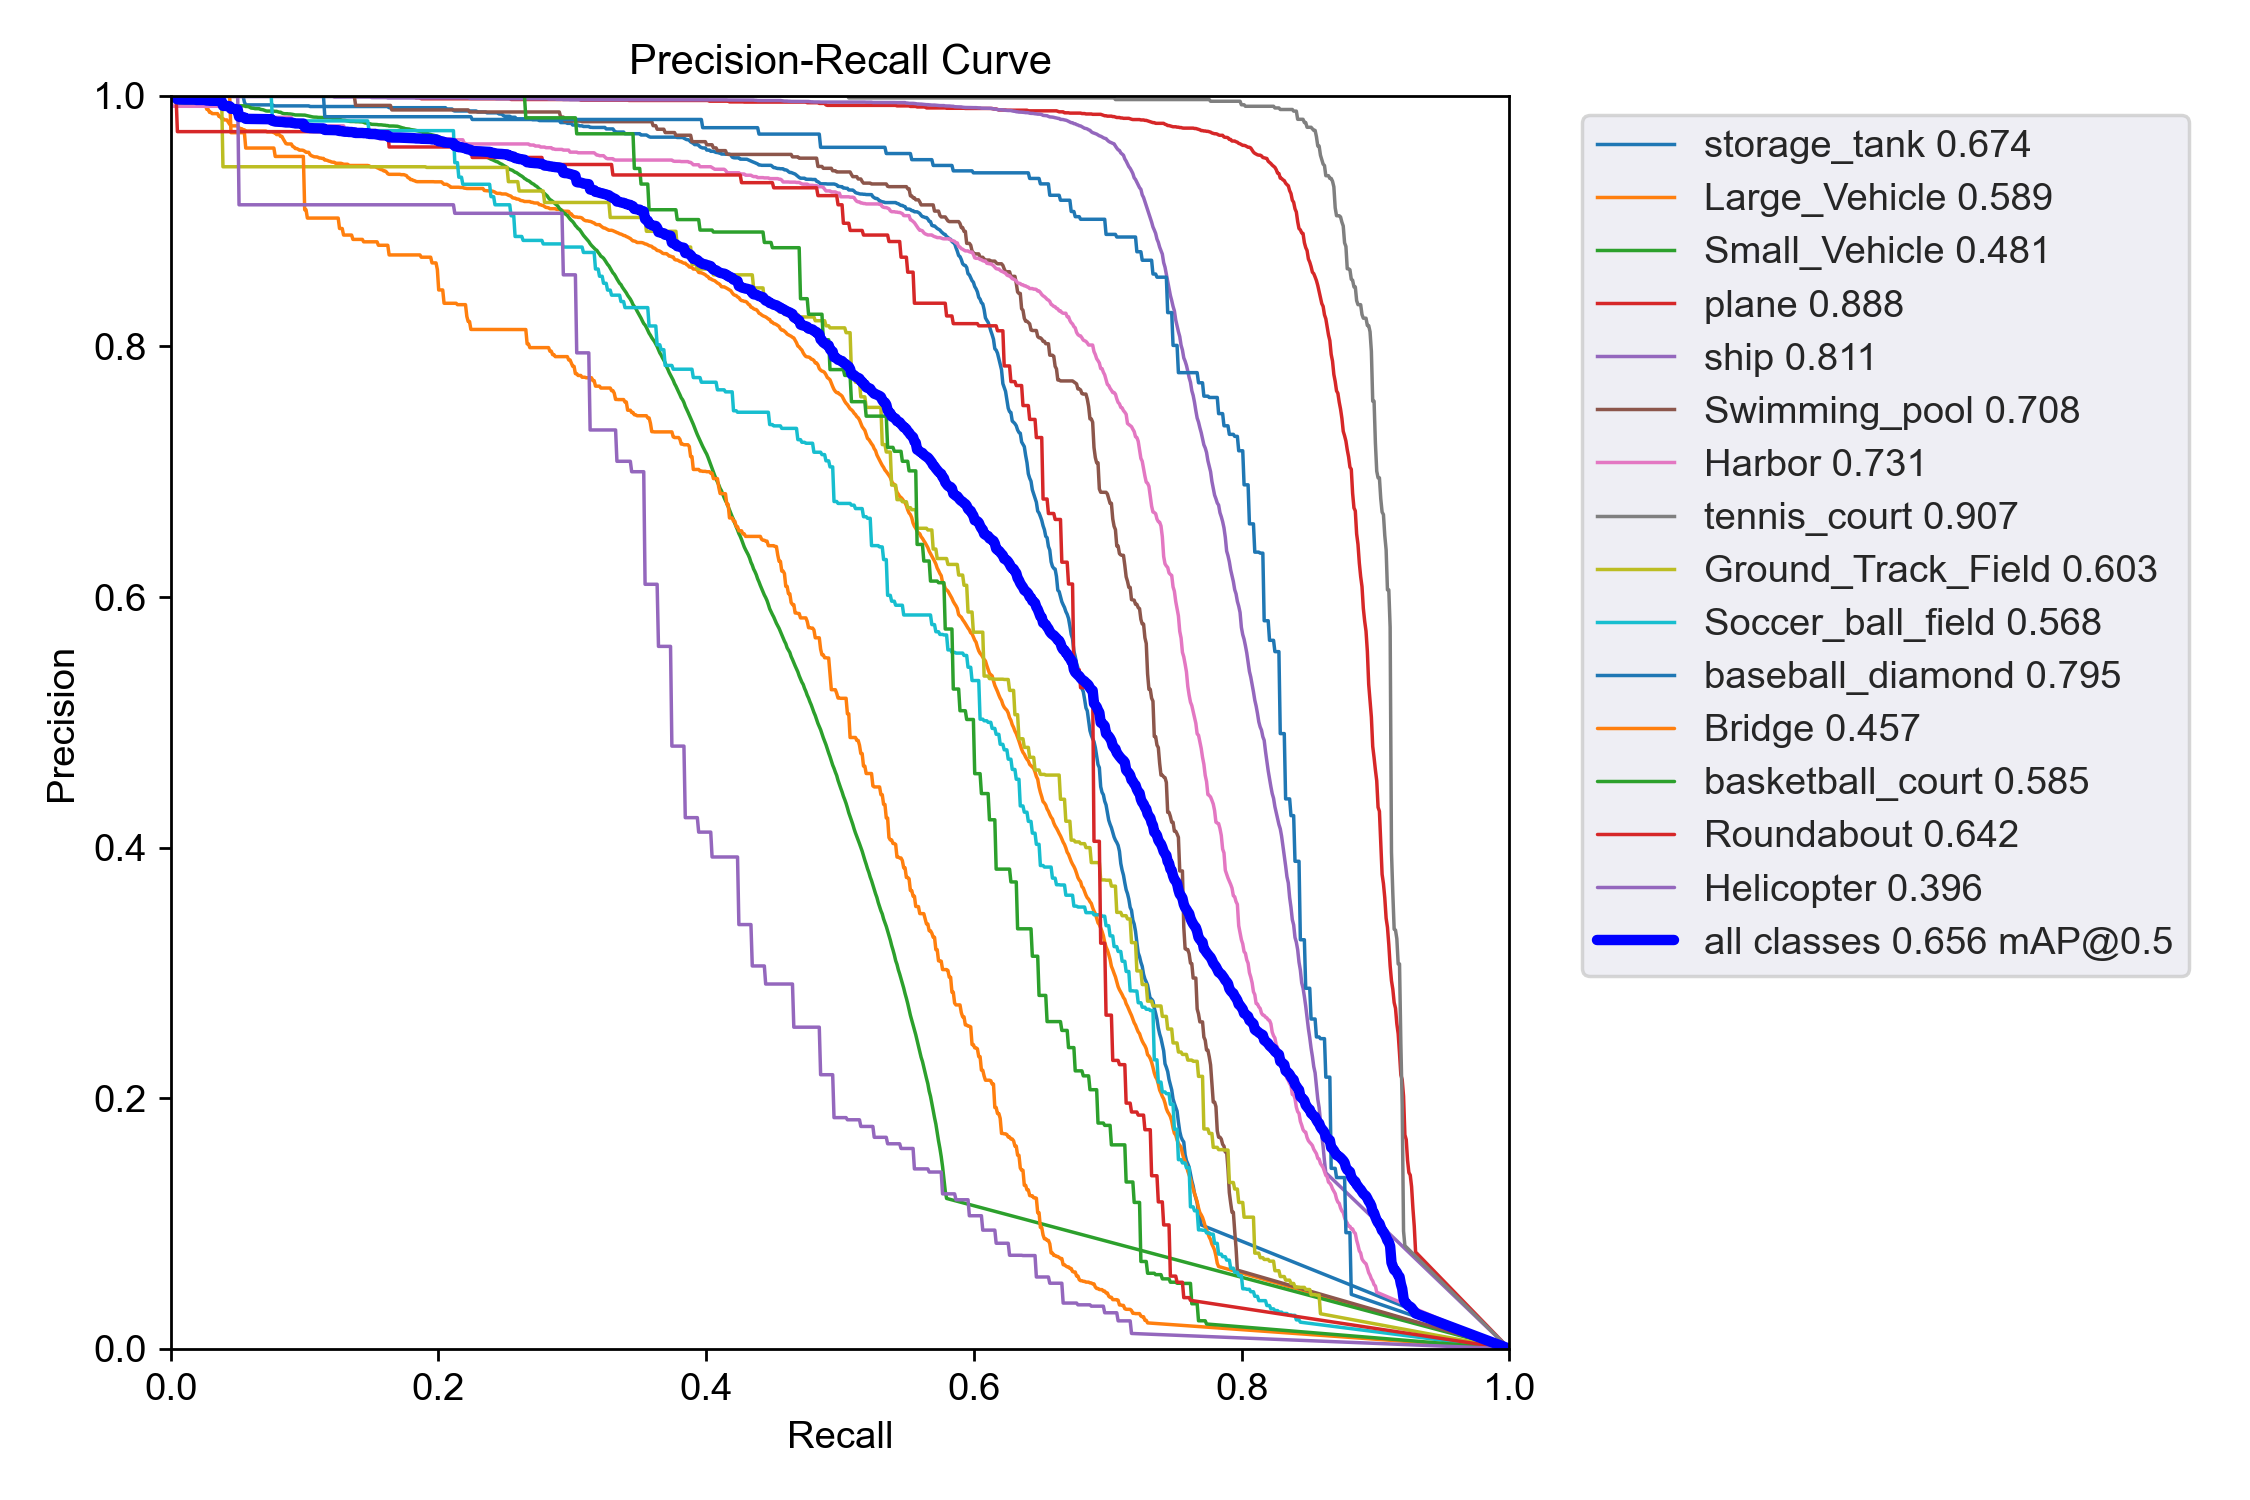

In [28]:
im = Image.open("runs/train/exp6/PR_curve.png")
im

Как можно видеть, удалось достич хороших результатов в распознавании объектов. Кроме этого посмотрим на процесс обучения:

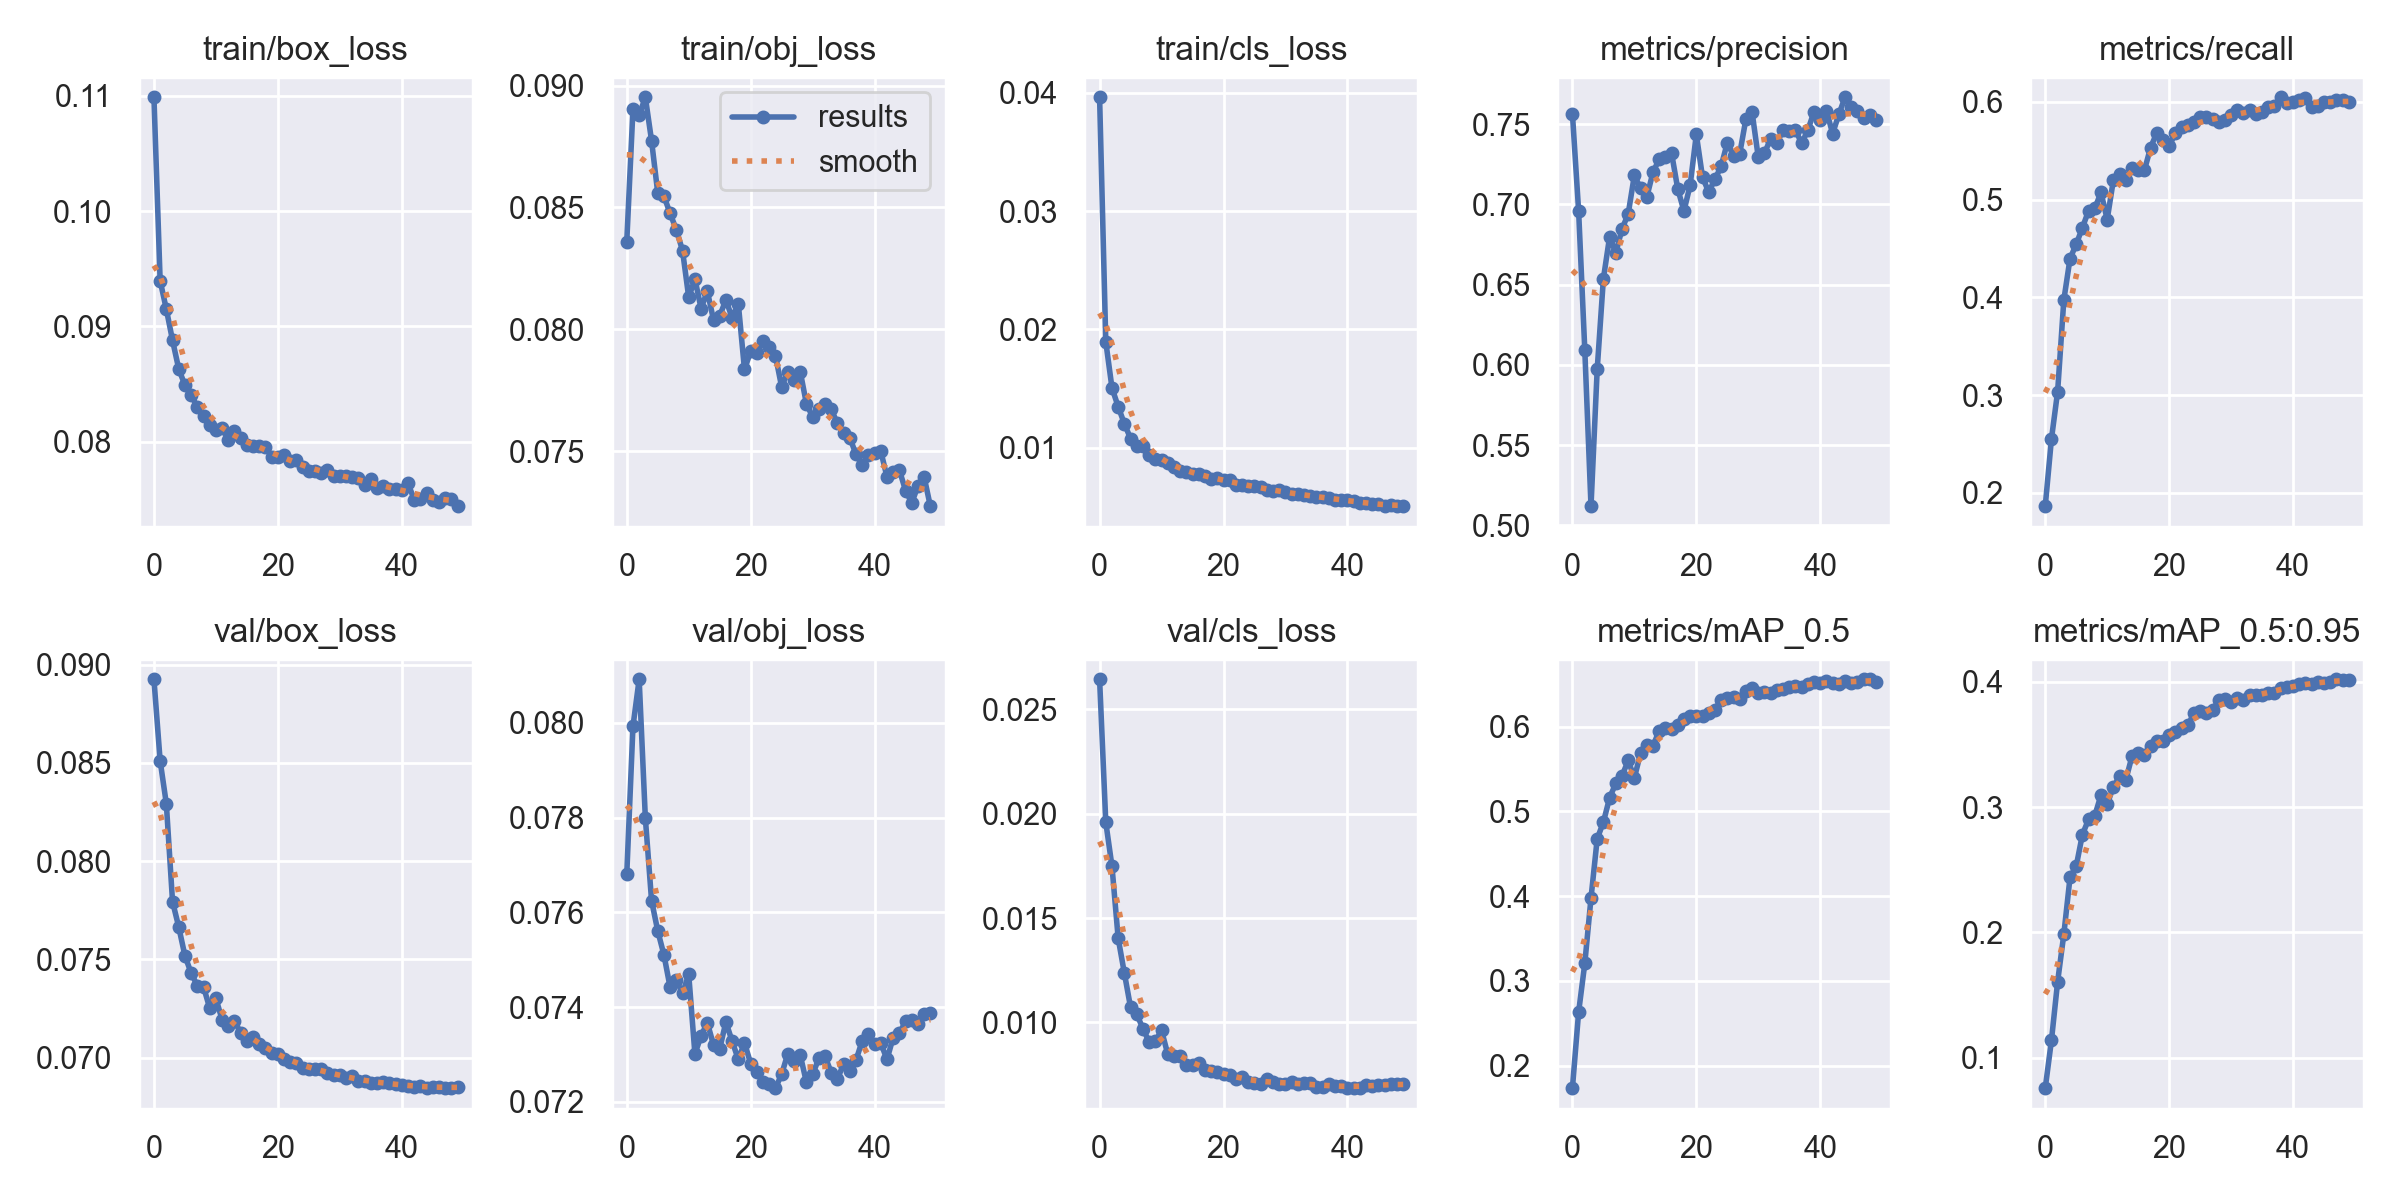

In [32]:
im = Image.open("runs/train/exp6/results.png")
im

Видно, что увеличивать количество эпох не имеет смысла, поскольку начинает расти ошибка, и метрика уже не увеличивается, т.е. при дальнейшем увеличении эпох будет происходить уже переобучение.

## Применение обученной модели

Теперь посмотрим на пример распознавания объектов обученной моделью:

In [29]:
!python detect.py --weights runs/train/exp6/weights/best.pt --source ../test/ --device 0

detect: weights=['runs/train/exp6/weights/best.pt'], source=../test/, data=data\coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs\detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5  v7.0-254-gba63208 Python-3.9.13 torch-2.1.2+cu121 CUDA:0 (NVIDIA GeForce RTX 2050, 4096MiB)

Fusing layers... 
Model summary: 157 layers, 7050580 parameters, 0 gradients, 15.9 GFLOPs
WARNING  NMS time limit 0.550s exceeded
image 1/2 C:\Users\Vlad\Desktop\Yolov5\test\P0037_4_3.jpg: 544x640 5 Small_Vehicles, 6 planes, 217.5ms
image 2/2 C:\Users\Vlad\Desktop\Yolov5\test\P0051_2_1.jpg: 608x640 60 Small_Vehicles, 6 tennis_courts, 2 Soccer_ball_fields, 1 baseball_diamond, 208.1ms
Speed: 1.5ms pre-process, 212.8

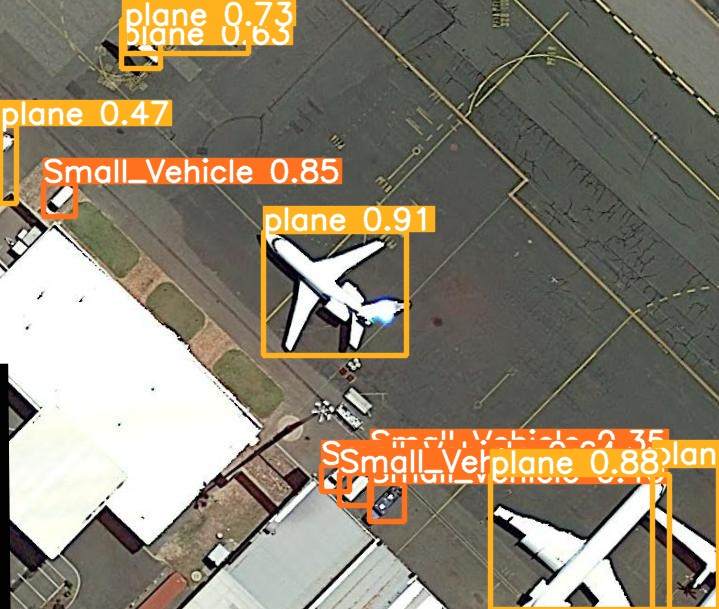

In [30]:
im = Image.open("runs/detect/exp3/P0037_4_3.jpg")
im

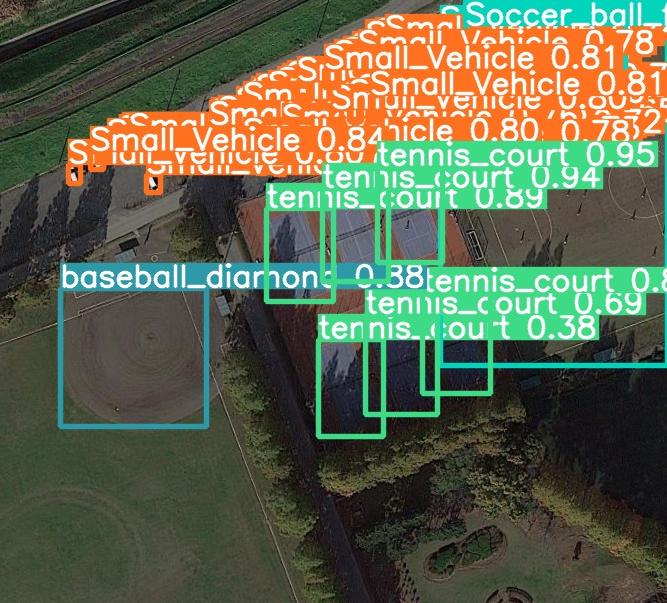

In [31]:
im = Image.open("runs/detect/exp3/P0051_2_1.jpg")
im